# Предсказание распределений вина по классам

In [25]:
##WRITE YOUR CODE HERE
import random
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from scipy.interpolate import interp1d 

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Загрузим классический учебный набор данных `load_wine()` с информацией о винах, следующей структуры:

* Classes: 3
* Samples per class: [59,71,48]
* Samples total: 178
* Dimensionality: 13
* Features: real, positive

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()

Посмотрим на его размерность:

In [3]:
##WRITE YOUR CODE HERE
print(wine.data.shape)

(178, 13)


Разделим данные на тренировочные и проверочные и переведём их в тензоры:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Создадим класс для нейронной сети: она будет состоять из входного слоя, функции активации сигмоды, скрытого слоя также с функцией активации сигмодой, выходного слоя с последующим переводом в вероятность при помощи функции softmax.

In [5]:
class WineNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = nn.Linear(2, n_hidden_neurons)
        self.activ1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = nn.Sigmoid()
        self.fc3 = nn.Linear(n_hidden_neurons, 3)
        self.sm = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

Создадим экземпляр класса с пятью нейронами на скрытом слое:

In [6]:
wine_net = WineNet(5)

Определим функцию потерь через кросс-энтропию, а в качестве оптимизатора возьмём Adam с шагом обучения 0,001.

In [7]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)

Обучим нашу нейронную сеть:

In [8]:
batch_size = 10

for epoch in range(5000):
    wine_net.train()
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        ##WRITE YOUR CODE HERE
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.inference(x_batch)
        loss_value = loss(preds, y_batch)
        
        loss_value.backward()
        optimizer.step()
        ##WRITE YOUR CODE HERE
        ##WRITE YOUR CODE HERE
        
    if epoch % 100 == 0:
        test_preds = wine_net(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.4074)
tensor(0.4074)
tensor(0.4630)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.5185)
tensor(0.6481)
tensor(0.6296)
tensor(0.6296)
tensor(0.6481)
tensor(0.6481)
tensor(0.6852)
tensor(0.6852)
tensor(0.6852)
tensor(0.7407)
tensor(0.7778)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8333)


Выведем полученные результаты в виде закрашенных множеств:

/home/liuhailin/miniconda3/envs/deep_ml/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_1300/404890737.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/torch/csrc/utils/tensor_new.cpp:278.)
  plt.scatter(X_train[indexes, 0],


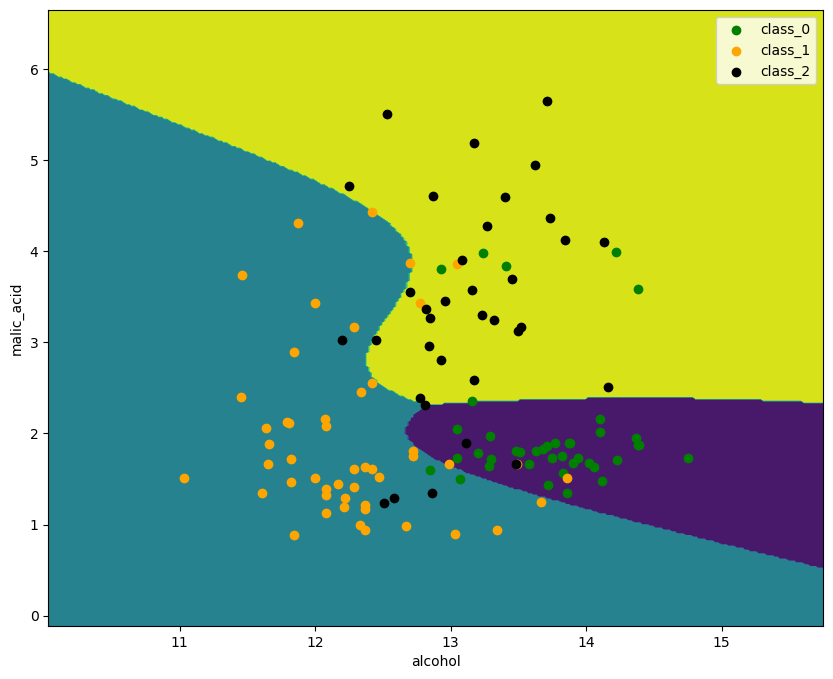

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class)

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i])
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Задание$^*$: построить ROC-кривую для этого множества. 

In [26]:
y_pred = wine_net.inference(X_test)
auc = roc_auc_score(
    y_true=y_test.numpy(),
    y_score=y_pred.data.numpy(),
    average="macro",
    multi_class="ovr"
    )
print(auc)

0.9235717574573479
